In [36]:
!pip install geopandas
!pip install ipywidgets
!pip install matplotlib
!pip install contextily

In [37]:
from google.colab import output
output.enable_custom_widget_manager()

In [38]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import matplotlib as mpl
from ipywidgets import interact, Dropdown, fixed

In [39]:
def load_us_states(shapefile_path):
    # Load the shapefile
    states = gpd.read_file(shapefile_path)
    # Filter for U.S. states only (assuming 'iso_a2' or similar column for country code)
    us_states = states[states['iso_a2'] == 'US']
    return us_states

In [40]:
def filter_by_age(traffic_data, age):
  if age is None:
    return traffic_data
  traffic_data['subject_age'] = pd.to_numeric(traffic_data['subject_age'], errors='coerce')
  traffic_data = traffic_data.dropna(subset=['subject_age'])
  traffic_data['subject_age'] = traffic_data['subject_age'].astype(int)
  min_age = int(age.split("-")[0])
  max_age = int(age.split("-")[1])
  traffic_data = traffic_data.where((traffic_data['subject_age'] >= min_age) & (traffic_data['subject_age'] <= max_age)).dropna()
  return traffic_data



In [41]:
def filter_by_race(traffic_data, race):
  if race is None:
    return traffic_data
  traffic_data = traffic_data.where(traffic_data['subject_race'] == race)
  print(traffic_data)
  return traffic_data

In [42]:
def filter_by_sex(traffic_data, sex):
  if sex is None:
    return traffic_data
  traffic_data = traffic_data.where(traffic_data['subject_sex'] == sex)
  return traffic_data

In [43]:
def load_traffic_stop_data(file_path, age=None, sex=None, race=None):
    # Initialize an empty DataFrame to store all states' data

    state_abbr_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
        'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
        'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
        'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
        'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
        'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
        'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }

    # Initialize an empty DataFrame to store all states' data
    traffic_data = pd.read_csv(file_path)

    # Check if 'state' column exists
    if 'state' not in traffic_data.columns:
        print("Missing 'state' column in the dataset.")
        return None

    traffic_data['subject_age'] = traffic_data['subject_age'].fillna('Unknown')
    traffic_data['subject_race'] = traffic_data['subject_race'].fillna('Unknown')
    traffic_data['subject_sex'] = traffic_data['subject_sex'].fillna('Unknown')

    # Aggregate by state to get the total count of stops per state
    traffic_data = filter_by_age(traffic_data,age)
    traffic_data = filter_by_race(traffic_data,race)
    traffic_data = filter_by_sex(traffic_data,sex)


    grouped_data = traffic_data.groupby(['state', 'subject_age', 'subject_race', 'subject_sex'], as_index=False)['count'].sum()

    # Map state abbreviations to full names
    grouped_data['state'] = grouped_data['state'].map(state_abbr_to_name)

    # Now aggregate by state, summing the 'count' column to get the total count per state
    aggregated_data = grouped_data.groupby('state', as_index=False)['count'].sum()
    aggregated_data = aggregated_data.rename(columns={'count': 'stop_count'})

    print("Aggregated Data by State:")

    print(aggregated_data)

    return aggregated_data

In [44]:
def merge_data(us_states, traffic_stops):
    # Merge the GeoDataFrame with the traffic stops data
    traffic_stops = traffic_stops.rename(columns={'state': 'name'})
    us_map = us_states.merge(traffic_stops, on='name', how='left')
    return us_map

In [45]:
def plot_choropleth(us_map):
    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Plot the choropleth without the legend parameter
    us_map.plot(
        column='stop_count',
        cmap='OrRd',
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8'
    )

    # Create a color bar as a separate item
    sm = plt.cm.ScalarMappable(cmap='OrRd', norm=mpl.colors.Normalize(vmin=us_map['stop_count'].min(), vmax=us_map['stop_count'].max()))
    sm._A = []  # Dummy array for the color bar

    # Add the color bar to the plot
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Traffic Stop Counts", fontsize=12)

    # Customize the plot
    ax.set_title("Traffic Stops by State", fontsize=15)
    ax.set_axis_off()  # Hide axes for a cleaner look
    plt.show()

In [46]:
def interactive_map(shapefile_path, data_file_path, age, sex, race):
    us_states = load_us_states(shapefile_path)
    traffic_stops = load_traffic_stop_data(data_file_path, age=age, sex=sex, race=race)
    print(traffic_stops)
    us_map = merge_data(us_states, traffic_stops)
    plot_choropleth(us_map)

In [47]:
def main():
    shapefile_path = '/content/ne_110m_admin_1_states_provinces.shp'
    data_file_path = '/content/aggregated_data.csv'

    # Load data
    age_dropdown = Dropdown(
        options=['Unknown', '20-29', '30-39', '40-49', None],
        value=None,
        description='Age:'
    )
    sex_dropdown = Dropdown(
        options=['Unknown', 'male', 'female', None],
        value=None,
        description='Sex:'
    )
    race_dropdown = Dropdown(
        options=['other', 'white', 'black', 'asian/pacific islander', 'hispanic', None],
        value=None,
        description='Race:'
    )


    # Display the interactive map with dropdowns for age, sex, and race filters
    interact(
        interactive_map,
        shapefile_path=fixed(shapefile_path),
        data_file_path=fixed(data_file_path),
        age=age_dropdown,
        sex=sex_dropdown,
        race=race_dropdown
    )

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


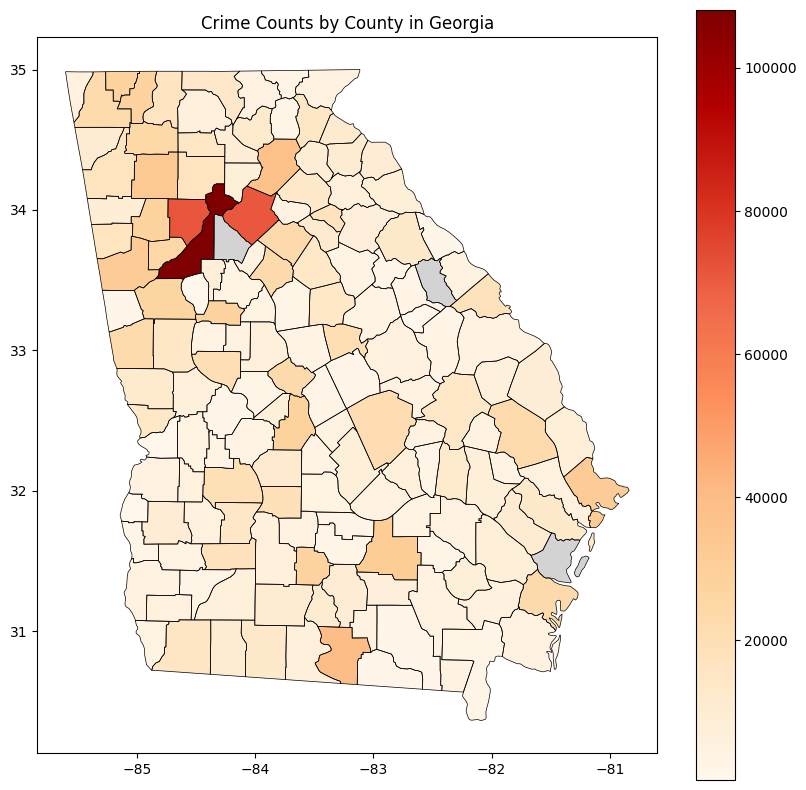

In [53]:

counties = gpd.read_file('/content/ne_10m_admin_2_counties.shp')

# Preview the dataset
georgia_counties = counties[counties['ISO_3166_2'] == 'US-13']


crime_data_path = "/content/crime_count_by_county.csv"  # Replace with your file path
crime_data = pd.read_csv(crime_data_path)

# Ensure county names match between datasets
georgia_counties['county_name'] = georgia_counties['NAME']  # Adjust column name if necessary

# Merge data without grouping
merged_data = georgia_counties.merge(crime_data, on='county_name', how='left')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.boundary.plot(ax=ax, linewidth=0.5, color="black")  # Plot county boundaries
merged_data.plot(column='crime_count', ax=ax, legend=True, cmap='OrRd', missing_kwds={
    "color": "lightgrey",
    "label": "No data"
})
plt.title("Crime Counts by County in Georgia")
plt.show()

In [49]:
if __name__ == "__main__":
    main()

interactive(children=(Dropdown(description='Age:', options=('Unknown', '20-29', '30-39', '40-49', None), value…